In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_triband_filter_design, make_reflection_design, get_minus_filter_spec

from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [2]:
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 1
batch_size = None
max_steps=1000
show = False


def exp(n_size, each_ot, target):
    np.random.seed()
    init_n = np.zeros(n_size) + 2
    film = EqOTFilm(init_n, each_ot * n_size, substrate=1.5)

    adam_optimizer = AdamFreeFormOptimizer(
        film, 
        target, 
        max_steps=max_steps, 
        alpha=alpha * 1e2 / (n_size * each_ot), # 0.01 for big OT films...
        record=True, 
        show=show, 
        n_min=n_min, # 1.5
        n_max=n_max, # 2.5
        wl_batch_size=batch_size # full 
    )

    adam_optimizer.optimize()
    return calculate_RMS_f_spec(film, target), film


#### Experiment: scan n_size AND each ot

In [ ]:

# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

# target = make_triband_filter_design().target_specs # 1 / wl_max - 1 / wl_min = 
wls = np.linspace(400., 700., 300)
target = [get_minus_filter_spec(wls)]
target_name = 'minus_filter'


n_size = 20
ot = 800
best_loss, best_film = exp(n_size, ot, target)


# save(f'./raw_result_sync/free_form_params_{target_name}_ot1e-1to1e3_nsize1to1e4.5_log_int_large_n_size', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))

0.21732609933361807


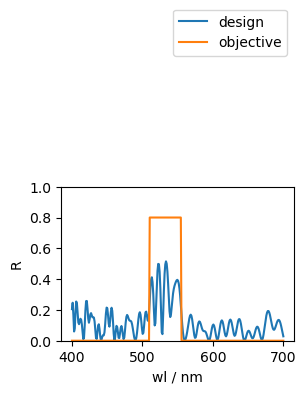

In [40]:
print(best_loss)
wls =np.linspace(400., 700., 300)
fig, ax = plt.subplots(1, 1)
ax.plot(wls, best_film.get_spec().get_R(), label='design')
ax.plot(wls, target[0].get_R(), label='objective')

ax.set_xlabel('wl / nm')
ax.set_ylabel('R')
ax.set_ylim(0, 1)
fig.set_size_inches(3, 2)
ax.legend(loc='center right', bbox_to_anchor=(1, 2))

In [4]:
each_ots = np.array([i for i in 10 ** np.linspace(-1, 3, 50)])
n_sizes = np.array([int(i) for i in 10 ** np.linspace(0, 3, 50)])

best_loss_arr_rep, best_film_arr_rep = load('./raw_result_total_ot/free_form_params_minus_filter_target_sparse')
best_loss_arr = best_loss_arr_rep[0]

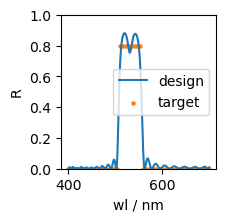

In [49]:
film = best_film_arr_rep[0][30][40]

wls = np.linspace(400., 700., 50)
target = get_minus_filter_spec(wls)
wls_full = np.linspace(wls[0], wls[-1], 500)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
ax.plot(wls_full, film.get_spec(0, wls_full).get_R(), label='design')
ax.scatter(wls, target.get_R(), label='target', s=5, color='C1')

ax.set_xlabel('wl / nm')
ax.set_ylabel('R')
ax.set_ylim(0, 1)
ax.legend()



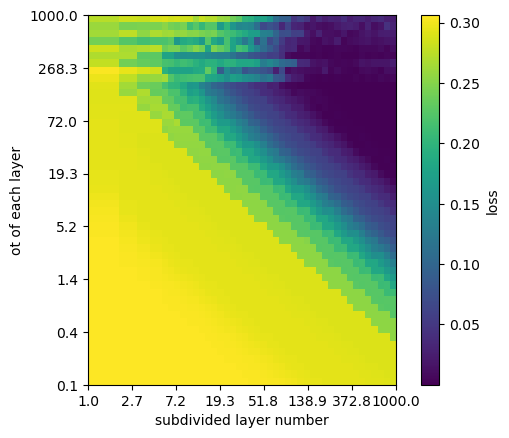

In [5]:
log = False
fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(best_loss_arr) if log else best_loss_arr, 
    extent=[n_sizes[0], n_sizes[-1], each_ots[-1], each_ots[0]], 
    aspect=1.2
)
ax.invert_yaxis()
ax.set_ylabel('ot of each layer')
ax.set_xlabel('subdivided layer number')

interval = 6
to_y = lambda x: (np.log10(x) - np.log10(each_ots[0])) * (-each_ots[0] + each_ots[-1]) / (-np.log10(each_ots[0]) + np.log10(each_ots[-1])) + each_ots[0]
to_x = lambda x: (np.log10(x) - np.log10(n_sizes[0])) * (-n_sizes[0] + n_sizes[-1] )/ (-np.log10(n_sizes[0]) + np.log10(n_sizes[-1])) + n_sizes[0]
make_ticks = lambda x: np.linspace(x[0], x[-1], x.shape[0] // interval)
make_tick_labels = lambda x, is_int=False: [f'{xi:.1f}' if not is_int else xi for xi in np.exp(np.linspace(np.log(x)[0], np.log(x)[-1], x.shape[0] // interval))]
ax.set_xticks(ticks=make_ticks(n_sizes), labels=make_tick_labels(n_sizes))
ax.set_yticks(ticks=make_ticks(each_ots), labels=make_tick_labels(each_ots))

# ax.set_ylim(5, None)
# ax.set_xlim(50, None)



cbar = fig.colorbar(s)
cbar.set_label('log10' if log else '' + 'loss')

fig.savefig('./results/tuning/sparse/sparse_ot', dpi=300)

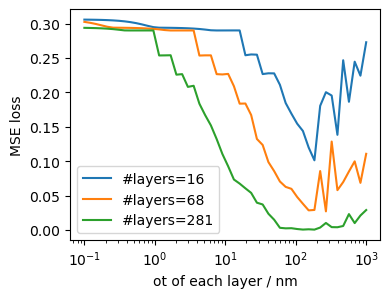

In [7]:
# fix layer number change ot each layer
fig, ax = plt.subplots(1, 1)

for layer_number_i in [20, 30, 40]:
    losses = best_loss_arr_rep[0, :, layer_number_i]
    ax.plot(each_ots, losses, label=f'#layers={n_sizes[layer_number_i]}')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()
ax.set_ylabel('MSE loss')
ax.set_xlabel('ot of each layer / nm')
fig.set_size_inches(4, 3)
fig.savefig('ot_each_layer_fix_layerot_dense_target', dpi=300, bbox_inches='tight')

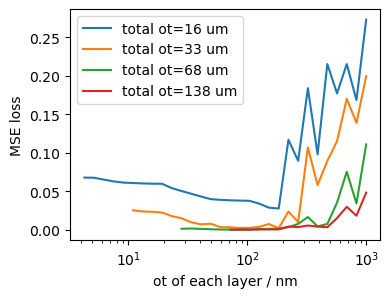

In [8]:
# fix total ot change ot each layer
fig, ax = plt.subplots(1, 1)

for total_ot_i in [20, 25, 30, 35]:
    i = np.arange(n_sizes.shape[0] - total_ot_i)
    losses = best_loss_arr_rep[0, - 1 - i, total_ot_i + i]
    ax.plot(each_ots[-1 - i], losses, label=f'total ot={n_sizes[total_ot_i] * each_ots[-1] / 1000:.0f} um')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()
ax.set_ylabel('MSE loss')
ax.set_xlabel('ot of each layer / nm')
fig.set_size_inches(4, 3)
fig.savefig('ot_each_layer_fix_totalot_dense_target', dpi=300, bbox_inches='tight')

In [89]:
print(best_loss_arr_rep)

[[[0.29664581 0.29664581 0.29664581 ... 0.28456611 0.28396509 0.28330381]
  [0.29664546 0.29664546 0.29664546 ... 0.28374199 0.28312826 0.28300813]
  [0.29664494 0.29664494 0.29664494 ... 0.28302047 0.28301349 0.28302475]
  ...
  [0.25605792 0.25605792 0.25605792 ... 0.09578196 0.09586699 0.08282293]
  [0.25429975 0.25429975 0.25429975 ... 0.16361943 0.16182315 0.15221179]
  [0.26562603 0.26562603 0.26562603 ... 0.16093599 0.15493661 0.15375719]]]
